<a href="https://colab.research.google.com/github/Dominika26/classification_tutorials_public/blob/main/Titanic_classifier_hard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy 
import statsmodels.formula.api as smf 
import statsmodels.api as sm 
#from lime import lime_tabular
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dtf = pd.read_csv('Titanic-Dataset.csv')
dtf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Data analysis**

In [ ]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

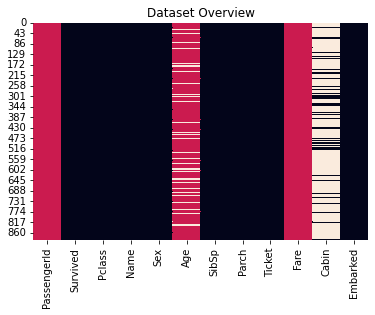

 Categerocial   Numeric   NaN 


In [ ]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
# ustalam, żę Passenger id jest moim primary key
# Zmieniam nazwę kolumny survived na Y, bo to jest nasza zmienna objaśniana
dtf = dtf.set_index("PassengerId")
dtf = dtf.rename(columns={"Survived":"Y"})

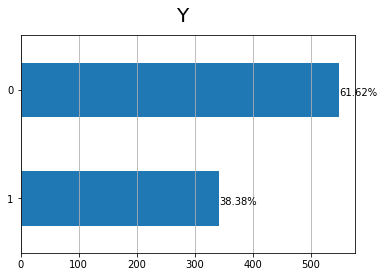

In [ ]:
#badam jaki % przeżyło, a jak nie
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

In [ ]:
features = []

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


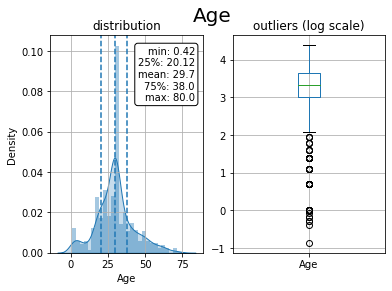

In [ ]:
#histogram- density of underlying distribution for a single numerical data.  

x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()


Pasażerowie byli dosyć młodzi, histogram przechyla się w lewą stronę, kwartyl trzeci wynosi 38 lat. To jak ułożony jest boxplot pokazuje, że było dużo dzieci. 

W kolejnym kroku chcę sprawdzić, czy wiek ma wpływ na prztrwanie, ale Y jest zmienną dyskretną, dlatego muszę trochę pozmieniać:
- podzelić populację na dwa zbiory: przetrwali, nie przetrwali 
- zrobić wykres który porówna gęstość obu zmiennych, jeżeli rozkłady są różne, to znaczy, że zmienna wiek wpływa na przetrwanie 
- pogrupuję zmienną numeryczną Age w podzbiory i zrobię wykres każdego podzbioru, jeżeli proporcja 1s jest podobna we wszytskich, to znaczy, że nie tłymaczy 
- narysuję boxploty dwóhc próbek  żeby zobaczyć wartości odstające 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KeyError: ignored

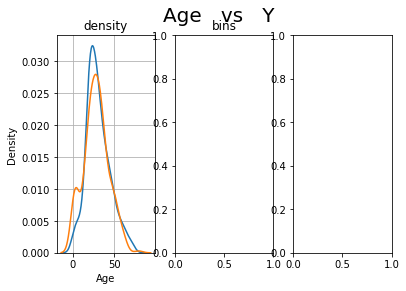

In [ ]:
cat, num = "Y", "Age"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

PO wykresach można zauważyć (niestety coś mi nie działa), że wiek ma wpływ na Y. Im mniejszy wiek, tym wyższa szansa na przeżycie. Jest skok na wykresie w przedziale wiekowym 0-16 lat, w sensie skoro pomarańczowy to że preżyli, to widać, że u dzieci więcej przeżyło. 

Ale możemy również wykonać test ANOVA. Jeżeli p_vlue<0.05, to odrzucamy hipotezę zerową o tym, że średnie są sobie równe

In [ ]:
cat, num = "Y", "Age"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

features.append("Age")

Anova F: the variables are Correlated (p-value: 0.039)


W kolejnym kroku badam czy płeć ma wpływ na przeżycie. Mam tutaj dwie zmienne dyskretne. 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


TypeError: ignored

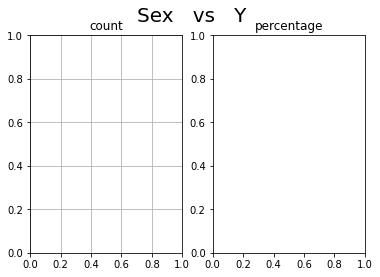

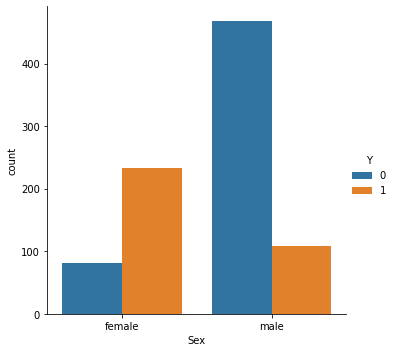

In [ ]:
x, y = "Sex", "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
### count
ax[0].title.set_text('count')
order = dtf.groupby(x)[y].count().index.tolist()
sns.catplot(x=x, hue=y, data=dtf, kind='count', order=order, ax=ax[0])
ax[0].grid(True)
### percentage
ax[1].title.set_text('percentage')
a = dtf.groupby(x)[y].count().reset_index()
a = a.rename(columns={y:"tot"})
b = dtf.groupby([x,y])[y].count()
b = b.rename(columns={y:0}).reset_index()
b = b.merge(a, how="left")
b["%"] = b[0] / b["tot"] *100
sns.barplot(x=x, y="%", hue=y, data=b,
            ax=ax[1]).get_legend().remove()
ax[1].grid(True)
plt.show()

Widać, że przeżył zdecydowanie większy % kobiet niż mężczyzn.
Możemy sprawdzić też tutaj korelację, ale mam 2 zmienne dyskretne, więc lepszy będzie test chi-kwadrat. Jeżeli p-value <0.05 to odrzucam hipotezę zerową i stwierdzam, że zmienne są skorelowane

In [ ]:
x, y = "Sex", "Y"
cont_table = pd.crosstab(index=dtf[x], columns=dtf[y])
chi2_test = scipy.stats.chi2_contingency(cont_table)
chi2, p = chi2_test[0], chi2_test[1]
n = cont_table.sum().sum()
phi2 = chi2/n
r,k = cont_table.shape
phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
rcorr = r-((r-1)**2)/(n-1)
kcorr = k-((k-1)**2)/(n-1)
coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")

features.append("Sex")

Cramer Correlation: 0.54 Significant (p-value:0.0)


Okazuje się, że zmienne wiek oraz płeć dobrze tłumaczą zmienną Y. Powinniśmy sprawdzić to dla każdej zmiennej żeby móc ocenić, które zmienne należy usunąć z modelu, np. Cabin okazuje się nie mieć znaczenia. 

**Feature engineering**
Chcę stworzyć zmienną na podstawie kolumny Cabin, która będzie dobrze tłumaczyła mój model. Zauważam, że pierwsza litera zmiennej Cabin, np. B96 wskazuje być może na to, że kajuta była umiejscowiona bliżej miejsca z łódkami.

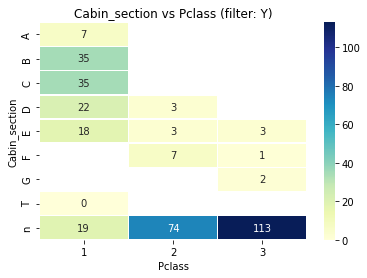

In [ ]:
## Create new column
dtf["Cabin_section"] = dtf["Cabin"].apply(lambda x: str(x)[0])
## Plot contingency table
cont_table = pd.crosstab(index=dtf["Cabin_section"], 
             columns=dtf["Pclass"], values=dtf["Y"], aggfunc="sum")
sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='.0f',
            linewidths=.5).set_title( 
            'Cabin_section vs Pclass (filter: Y)' )
features.append("Cabin_section")

Tabela kontyngencji pokazuje ile ludzi umierało w zależności od miejsca kajuty i klasy. Zachowam zmienną na później zamiast zmiennej cabin.

**Preprocessing**

Przygotowanie surowych danych do wykorzystania w modelach. Należy:
- każdy wiersz musi przedstawiać inną obserwację, a każda kolumna inną cechę, dlatego np. kolumna PassengerId nie będzie tłumaczyć 
- Zbiór musi być podzielony na zbiór treningowy i testowy 
- brakujące wartości powinny być czymś zastąpione 
- zmienne dsykretne należy przkodować na zmienne numeryczne 
- powinniśmy przeskalować dane, pozwala to na normalizację i przyspiesza działanie algorytmu

1. Podział danych 

In [ ]:
features.append("Embarked")
features.append("Pclass")
features.append("Fare")
features.append("Parch")
features.append("SibSp")

In [ ]:

dtf = dtf[features+["Y"]]
dtf.head()

,Age,Sex,Cabin_section,Embarked,Pclass,Fare,Parch,SibSp,Y
PassengerId,,,,,,,,,
1,22.0,male,n,S,3,7.2500,0,1,0
2,38.0,female,C,C,1,71.2833,0,1,1
3,26.0,female,n,S,3,7.9250,0,0,1
4,35.0,female,C,S,1,53.1000,0,1,1
5,35.0,male,n,S,3,8.0500,0,0,0


In [ ]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())


X_train shape: (623, 8) | X_test shape: (268, 8)
y_train mean: 0.38 | y_test mean: 0.38
9 features: ['Age', 'Sex', 'Cabin_section', 'Embarked', 'Pclass', 'Fare', 'Parch', 'SibSp']


Kolumna Age zawiera brakujące dane i trzeba coś z tym zrobić. Użyjemy średniej kolumnu 

In [ ]:
dtf_train["Age"] = dtf_train["Age"].fillna(dtf_train["Age"].mean())
dtf_test["Age"] = dtf_test["Age"].fillna(dtf_test["Age"].mean())

In [ ]:
dtf_train["Embarked"] = dtf_train["Embarked"].fillna(dtf_train["Embarked"].mode())

Teraz musimy przkodować zmienne dyskretne. 

In [ ]:
dtf_test["Embarked"] = dtf_test["Embarked"].fillna(dtf_test["Embarked"].mode())

In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_train["Sex"], 
                       prefix="Sex",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Sex", axis=1).head() )
## drop the original categorical column
dtf_train = dtf_train.drop("Sex", axis=1)




                Sex  Sex_male
PassengerId                  
390          female         0
491            male         1
233            male         1
783            male         1
831          female         0


In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_test["Sex"], 
                       prefix="Sex",drop_first=True)
dtf_test= pd.concat([dtf_test, dummy], axis=1)
print( dtf_test.filter(like="Sex", axis=1).head() )
## drop the original categorical column
dtf_test = dtf_test.drop("Sex", axis=1)

                Sex  Sex_male
PassengerId                  
766          female         0
860            male         1
669            male         1
557          female         0
870            male         1


In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_train["Embarked"], 
                       prefix="Embarked",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Embarked", axis=1).head() )
## drop the original categorical column
dtf_train = dtf_train.drop("Embarked", axis=1)

            Embarked  Embarked_Q  Embarked_S
PassengerId                                 
390                C           0           0
491                S           0           1
233                S           0           1
783                S           0           1
831                C           0           0


In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_test["Embarked"], 
                       prefix="Embarked",drop_first=True)
dtf_test= pd.concat([dtf_test, dummy], axis=1)
print( dtf_test.filter(like="Embarked", axis=1).head() )
## drop the original categorical column
dtf_test = dtf_test.drop("Embarked", axis=1)

            Embarked  Embarked_Q  Embarked_S
PassengerId                                 
766                S           0           1
860                C           0           0
669                S           0           1
557                C           0           0
870                S           0           1


In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_test["Pclass"], 
                       prefix="Pclass",drop_first=True)
dtf_test= pd.concat([dtf_test, dummy], axis=1)
print( dtf_test.filter(like="Pclass", axis=1).head() )
## drop the original categorical column
dtf_test = dtf_test.drop("Pclass", axis=1)

KeyError: ignored

In [ ]:
dummy = pd.get_dummies(dtf_train["Pclass"], 
                       prefix="Pclass",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Pclass", axis=1).head() )
## drop the original categorical column
dtf_train = dtf_train.drop("Pclass", axis=1)

             Pclass  Pclass_2  Pclass_3
PassengerId                            
390               2         1         0
491               3         0         1
233               2         1         0
783               1         0         0
831               3         0         1


In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_train["Cabin_section"], 
                       prefix="Cabin_section",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Cabin_section", axis=1).head() )
## drop the original categorical column
dtf_train = dtf_train.drop("Cabin_section", axis=1)

            Cabin_section  Cabin_section_B  Cabin_section_C  Cabin_section_D  \
PassengerId                                                                    
390                     n                0                0                0   
491                     n                0                0                0   
233                     n                0                0                0   
783                     D                0                0                1   
831                     n                0                0                0   

             Cabin_section_E  Cabin_section_F  Cabin_section_G  \
PassengerId                                                      
390                        0                0                0   
491                        0                0                0   
233                        0                0                0   
783                        0                0                0   
831                        0               

In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_test["Cabin_section"], 
                       prefix="Cabin_section",drop_first=True)
dtf_test= pd.concat([dtf_test, dummy], axis=1)
print( dtf_test.filter(like="Cabin_section", axis=1).head() )
## drop the original categorical column
dtf_test = dtf_test.drop("Cabin_section", axis=1)

            Cabin_section  Cabin_section_B  Cabin_section_C  Cabin_section_D  \
PassengerId                                                                    
766                     D                0                0                1   
860                     n                0                0                0   
669                     n                0                0                0   
557                     A                0                0                0   
870                     n                0                0                0   

             Cabin_section_E  Cabin_section_F  Cabin_section_G  \
PassengerId                                                      
766                        0                0                0   
860                        0                0                0   
669                        0                0                0   
557                        0                0                0   
870                        0               

In [ ]:

dtf_train.head()

,Age,Fare,Parch,SibSp,Y,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Cabin_section_B,Cabin_section_C,Cabin_section_D,Cabin_section_E,Cabin_section_F,Cabin_section_G,Cabin_section_T,Cabin_section_n
PassengerId,,,,,,,,,,,,,,,,,,
390,17.000000,12.0000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
491,30.411034,19.9667,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
233,59.000000,13.5000,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
783,29.000000,30.0000,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
831,15.000000,14.4542,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1


Scaling the features 

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]
dtf_scaled.head()

,Age,Fare,Parch,SibSp,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Cabin_section_B,Cabin_section_C,Cabin_section_D,Cabin_section_E,Cabin_section_F,Cabin_section_G,Cabin_section_T,Cabin_section_n,Y
PassengerId,,,,,,,,,,,,,,,,,,
390,0.208344,0.023422,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
491,0.376866,0.038972,0.0,0.125,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
233,0.736115,0.026350,0.0,0.000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
783,0.359135,0.058556,0.0,0.000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
831,0.183212,0.028213,0.0,0.125,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [ ]:
dtf_test.head()

,Age,Fare,Parch,SibSp,Y,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Cabin_section_B,Cabin_section_C,Cabin_section_D,Cabin_section_E,Cabin_section_F,Cabin_section_G,Cabin_section_n
PassengerId,,,,,,,,,,,,,,,,,
766,51.000000,77.9583,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
860,28.001991,7.2292,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
669,43.000000,8.0500,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1
557,48.000000,39.6000,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
870,4.000000,11.1333,1,1,1,1,0,1,0,1,0,0,0,0,0,0,1


In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_test.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_test.drop("Y", axis=1).columns, index=dtf_test.index)
dtf_scaled["Y"] = dtf_test["Y"]
dtf_scaled.head()

,Age,Fare,Parch,SibSp,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Cabin_section_B,Cabin_section_C,Cabin_section_D,Cabin_section_E,Cabin_section_F,Cabin_section_G,Cabin_section_n,Y
PassengerId,,,,,,,,,,,,,,,,,
766,0.719747,0.296419,0.0,0.125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
860,0.389221,0.027487,0.0,0.000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
669,0.604771,0.030608,0.0,0.000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
557,0.676631,0.150570,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
870,0.044266,0.042332,0.2,0.125,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


**Feature selection**

Process of selecting a susbset of relevant variables. Pclass is highly correlated with cabin_section 

Text(0.5, 1.0, 'pearson correlation')

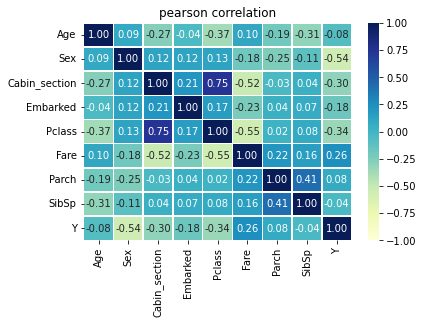

In [ ]:
corr_matrix = dtf.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

First method of feature selection- regularization and compare it with ANOVA. The blue features are selected by both ANOVA and LASSO.

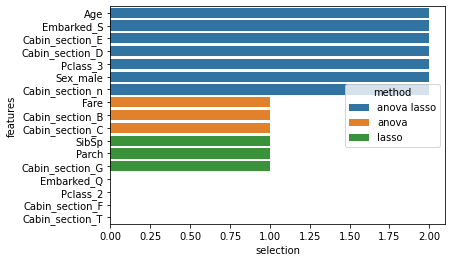

In [ ]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

Random forest as the second way of feature selection

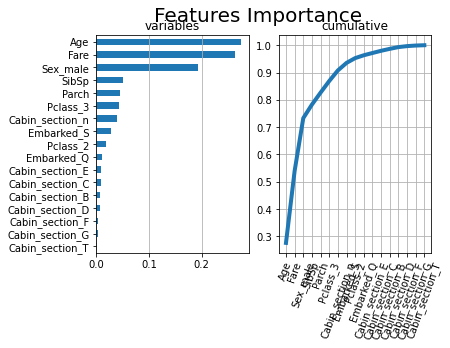

In [ ]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_

dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

Tutaj widać, że najważeniejszymi czynnikami są Age oraz Fare. Usuwam część niepotrzenych zmiennych.

In [ ]:
X_names = ["Age", "Fare", "Sex_male", "SibSp", "Pclass_3", "Parch",
"Cabin_section_n", "Embarked_S", "Pclass_2", "Cabin_section_F", "Cabin_section_E", "Cabin_section_D"]
X_train = dtf_train[X_names].values
y_train = dtf_train["Y"].values


In [ ]:

X_test = dtf_test[X_names].values
y_test = dtf_test["Y"].values

**Model design**
Gradient boosting- It’s a machine learning technique that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Basically it’s similar to a Random Forest with the difference that every tree is fitted on the error of the previous one. I use random serach to find the best hiperparameters

In [ ]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=1000, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Tu już nie mam czasu, długo się ładuje, ale powinno wyjść 
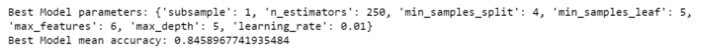

K-fold cross-validation

In [ ]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
   prediction = model.fit(X_train[train],
                y_train[train]).predict_proba(X_train[test])
   fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1])
   tprs.append(scipy.interp(mean_fpr, fpr, tpr))
   roc_auc = metrics.auc(fpr, tpr)
   aucs.append(roc_auc)
   plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = 
            %0.2f)' % (i, roc_auc))
   i = i+1
   
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = 
         %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

SyntaxError: ignored

Dostosowanie modelu do danych 

In [ ]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## call model
model = ensemble.GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
## test
#prediciton that the first one is the probability that the observation is  1
predicted_prob = model.predict_proba(X_test)[:,1]
#prediction that of the label (1 or 0)
predicted = model.predict(X_test)

**Evaluation**

Accuracy, AUC, Precision and recall
Precision- fraction of 1s (or 0s) that the model predicted correctly among all predicted 1s (or 0s). 
- Recall- portion of 1s (or 0s) that the model predictedc correctly among 1s (or 0s) 
- Combining Precision and Recall gives F1

In [ ]:
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.87
Auc: 0.91
Recall (all 1s predicted right): 0.82
Precision (confidence when predicting a 1): 0.85
Detail:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       165
           1       0.85      0.82      0.83       103

    accuracy                           0.87       268
   macro avg       0.87      0.86      0.86       268
weighted avg       0.87      0.87      0.87       268



Confusion matrix

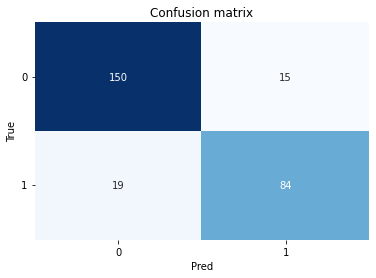

In [ ]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

Choosing threshold to minimize the F1-score

In [ ]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
        dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
dic_scores["precision"].append(metrics.precision_score(yy_test, predicted))
dic_scores["recall"].append(metrics.recall_score(yy_test, predicted))
dic_scores["f1"].append(metrics.f1_score(yy_test, predicted))
        
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
dtf_scores.plot(ax=ax, title="Threshold Selection")
plt.show()

IndentationError: ignored

**Explainability**